In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(11)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
"""
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import seaborn
seaborn.set()

## Clean and Merge Datasets (Eren)

In [2]:
# Enter data paths for raw_text version and parsed_text version
data_raw = "./data/reviews_raw.json"
data_parsed = "./data/reviews_parsed.json"

data_with_raw = pd.read_json(data_raw, lines=True)
data_with_parsed = pd.read_json(data_parsed, lines=True)

In [3]:
new_df = pd.merge(data_with_parsed, data_with_raw, on=["review_id"])

In [4]:
new_df = new_df.rename(columns={"rating_x": "rating", "user_id_x": "user_id", "rating_x": "rating",
                       "book_id_x": "book_id",})
selected_cols = ["user_id", "book_id", "review_sentences", "rating", 
                 "timestamp", "n_votes", "n_comments", "has_spoiler"]
new_df = new_df[selected_cols]

In [5]:
new_df.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,8842281e1d1347389f2ab93d60773d4d,18245960,"[[0, This is a special book.], [0, It started ...",5,2017-08-30,28,1,True
1,8842281e1d1347389f2ab93d60773d4d,16981,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,2017-03-22,1,0,False
2,8842281e1d1347389f2ab93d60773d4d,28684704,"[[0, A fun, fast paced science fiction thrille...",3,2017-03-20,22,0,True
3,8842281e1d1347389f2ab93d60773d4d,27161156,"[[0, Recommended reading to understand what is...",0,2016-11-09,5,1,False
4,8842281e1d1347389f2ab93d60773d4d,25884323,"[[0, I really enjoyed this book, and there is ...",4,2016-04-25,9,1,True


In [6]:
new_df.shape

(1378033, 8)

In [7]:
# Dataset reduction

print(f"number of unique books at the beginning: {new_df.book_id.nunique()}")

select_number = 15000
chosen_books = new_df.groupby("book_id")["has_spoiler"].mean().sort_values(ascending=False).keys()[:select_number].tolist()
reduced_df = new_df[new_df.book_id.isin(chosen_books)]

print(f"number of unique books at the end: {reduced_df.book_id.nunique()}")

print(f"Shape at the end: {reduced_df.shape}")

number of unique books at the beginning: 25475
number of unique books at the end: 15000
Shape at the end: (662210, 8)


In [8]:
print(f"ratio of non-spoiler labels: {reduced_df.has_spoiler.value_counts()[0] / len(reduced_df)}%")

ratio of non-spoiler labels: 0.9018876187312181%


In [9]:
reduced_df = reduced_df.reset_index(drop=True)
reduced_df.to_json("./data/reduced.json")

In [10]:
reduced_df.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,8842281e1d1347389f2ab93d60773d4d,18245960,"[[0, This is a special book.], [0, It started ...",5,2017-08-30,28,1,True
1,8842281e1d1347389f2ab93d60773d4d,28684704,"[[0, A fun, fast paced science fiction thrille...",3,2017-03-20,22,0,True
2,8842281e1d1347389f2ab93d60773d4d,25884323,"[[0, I really enjoyed this book, and there is ...",4,2016-04-25,9,1,True
3,8842281e1d1347389f2ab93d60773d4d,19398490,"[[0, A beautiful story.], [0, It is rare to en...",4,2016-09-20,35,5,False
4,8842281e1d1347389f2ab93d60773d4d,22816087,"[[0, I love Stephenson - and this was another ...",5,2016-12-14,40,6,False


In [11]:
# TODO change at the end
df = pd.read_json("./data/reduced.json")

In [12]:
df.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,8842281e1d1347389f2ab93d60773d4d,18245960,"[[0, This is a special book.], [0, It started ...",5,2017-08-30,28,1,True
1,8842281e1d1347389f2ab93d60773d4d,28684704,"[[0, A fun, fast paced science fiction thrille...",3,2017-03-20,22,0,True
2,8842281e1d1347389f2ab93d60773d4d,25884323,"[[0, I really enjoyed this book, and there is ...",4,2016-04-25,9,1,True
3,8842281e1d1347389f2ab93d60773d4d,19398490,"[[0, A beautiful story.], [0, It is rare to en...",4,2016-09-20,35,5,False
4,8842281e1d1347389f2ab93d60773d4d,22816087,"[[0, I love Stephenson - and this was another ...",5,2016-12-14,40,6,False


## Preprocess review_text (Melisa)

In [13]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def process_review_text(val):
    clean_test = []
    for sentence in val:
        # Tokenize the sentence
        words = word_tokenize(sentence[1])
        # Lowercase and remove non-alphanumeric characters
        words = [word.lower() for word in words if word.isalnum()]
        # Remove stopwords 
        words = [word for word in words if word not in stop_words]
        # Append the cleaned sentence to the cleaned dataset
        
        #LEMMATIZATION ÇOK BİR ŞEY DEĞİŞTİRMİYOR, YETERLİ Mİ YOKSA STEMMİNG Mİ YAPMALIYIZ? İLERDE DURUMA GÖRE BURAYA GERİ DÖN
        normalized_words = [lemmatizer.lemmatize(word) for word in words]
        clean_test.append(normalized_words)
        
    
    # Build a vocabulary
    vocab = set(word for sentence in clean_test for word in sentence)
    word_to_index = {word: index for index, word in enumerate(vocab)}

    # NUMERICAL REPRESENTATION
    numerical_data = [[word_to_index[word] for word in sentence] for sentence in clean_test]
    
    
    # Padding sequences / BAŞLANGIÇ OLARAK 13 SEÇTİM AMA CÜMLE UZUNLUĞU MEANİ 8, OLABİLDİĞİNCE ACCURATE OLSUN DİYE. EĞER HIZDAN DOLAYI
    # SIKINTI YAŞAMAYA BAŞLARSAK BURAYI 8-13 ARASI GİTTİKÇE AŞAĞI ÇEKEBİLİRİZ.
    max_sequence_length = 13
    padded_data = [seq[:max_sequence_length] + [0] * max(0, max_sequence_length - len(seq)) for seq in numerical_data]
    
    
    padded_data = torch.tensor(padded_data)
    #print(padded_data)

    #SPOILER LABELS
    label_lst = [i[0] for i in val]
    labels = torch.tensor(label_lst)

    dataset = TensorDataset(padded_data, labels)
        
    return dataset

In [14]:

# WORKING ON A SMALL SUBSET FOR NOW JUST TO MAKE SURE EVERYTHING WORKS
smaller_df = df.iloc[:20000]
#print(smaller_df.shape)
#print(df["review_sentences"])


smaller_df["test"] = smaller_df["review_sentences"].apply(process_review_text)
#print(smaller_df["test"].describe)


KeyboardInterrupt: 

In [15]:
print(smaller_df["test"][1])

KeyError: 'test'

## Basic Data Analysis (Melisa)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 662210 entries, 0 to 662209
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           662210 non-null  object        
 1   book_id           662210 non-null  int64         
 2   review_sentences  662210 non-null  object        
 3   rating            662210 non-null  int64         
 4   timestamp         662210 non-null  datetime64[ns]
 5   n_votes           662210 non-null  int64         
 6   n_comments        662210 non-null  int64         
 7   has_spoiler       662210 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 41.0+ MB


In [17]:
df.describe()

,book_id,rating,timestamp,n_votes,n_comments
count,6.622100e+05,662210.000000,662210,662210.000000,662210.000000
mean,1.531736e+07,3.698121,2015-04-10 07:52:39.047432192,3.432511,0.960691
min,1.000000e+00,0.000000,2007-02-27 00:00:00,-3.000000,-2.000000
25%,9.462795e+06,3.000000,2014-01-05 00:00:00,0.000000,0.000000
50%,1.583998e+07,4.000000,2015-08-16 00:00:00,0.000000,0.000000
75%,2.208210e+07,5.000000,2016-10-16 00:00:00,2.000000,0.000000
max,3.632868e+07,5.000000,2017-11-05 00:00:00,3167.000000,1335.000000
std,8.631684e+06,1.257962,NaN,19.021772,5.610807


In [18]:
df.isna().values.any()

False

<Axes: xlabel='rating', ylabel='n_votes'>

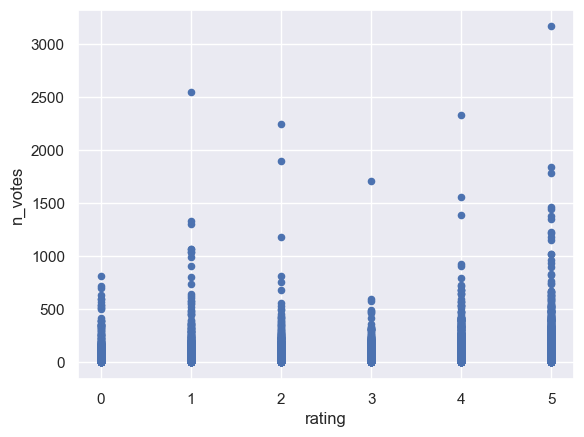

In [19]:
df.plot(kind='scatter', x='rating', y='n_votes')

<Axes: xlabel='rating', ylabel='n_comments'>

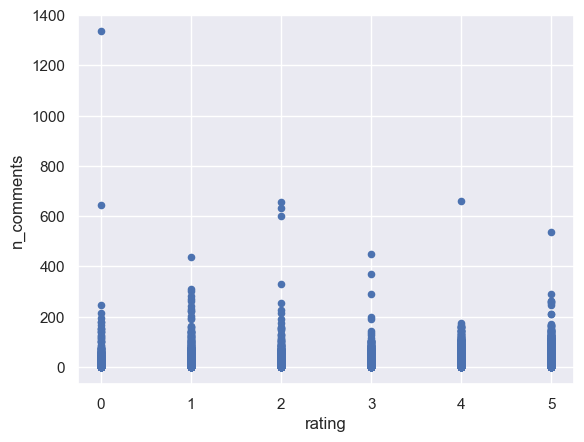

In [20]:
df.plot(kind='scatter', x='rating', y='n_comments')

<Axes: xlabel='n_votes', ylabel='n_comments'>

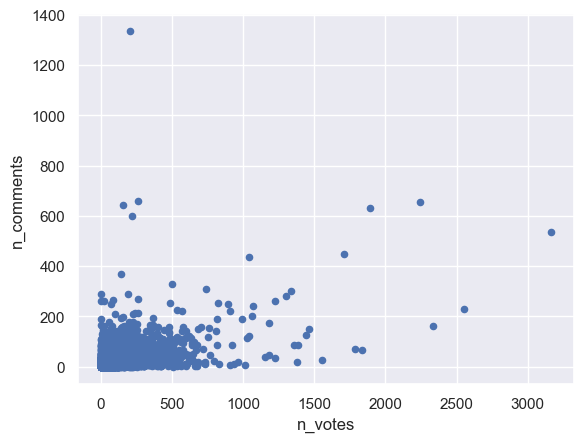

In [21]:
df.plot(kind='scatter', x='n_votes', y='n_comments')

## Normalize and Feature Scale the Data (Eren)

In [47]:
train, test = train_test_split(df, test_size=0.2)

In [50]:
def outlier_detection_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.hist(train[column], log=True, bins=30)
    ax1.set_title(f'Histogram of {column}')

    ax2.boxplot(train[column], vert=False)
    ax2.set_title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()

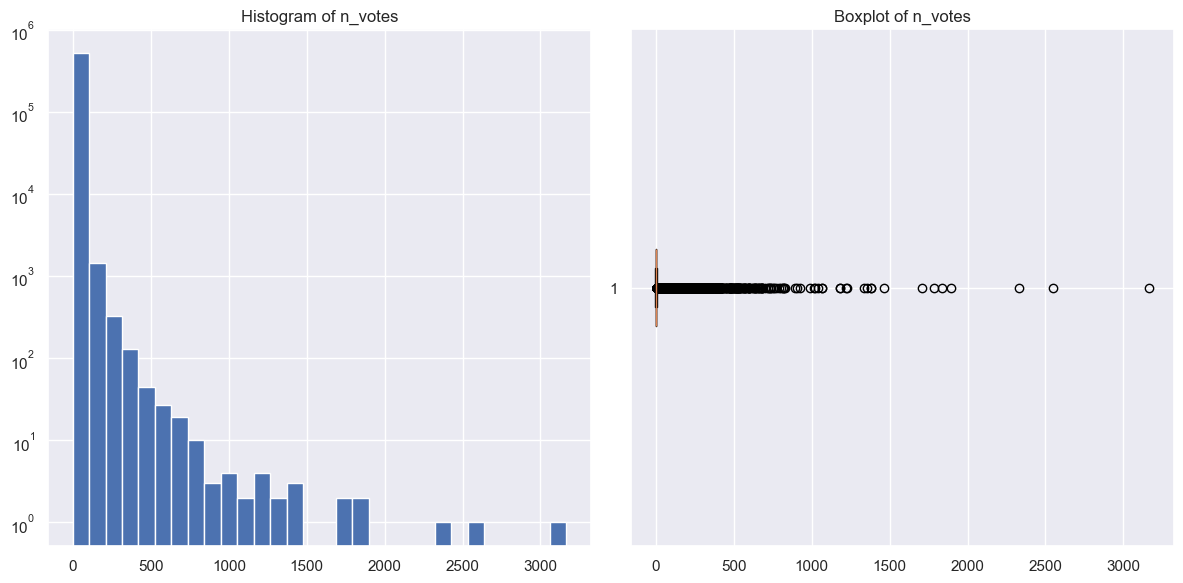

In [51]:
# We need to detect ourliers in numeric columns before scaling
outlier_detection_plot("n_votes")

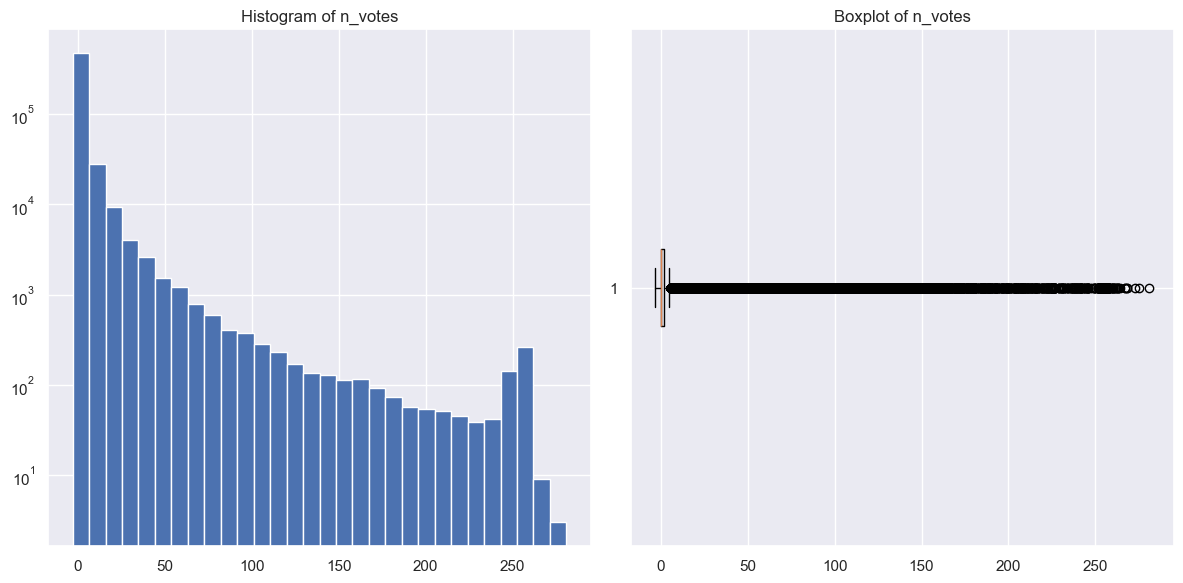

In [52]:
# FIXED VERSION OF N_VOTES
train["n_votes"] = train["n_votes"].apply(lambda x: 250+(x//100) if x>250 else x)

outlier_detection_plot("n_votes")

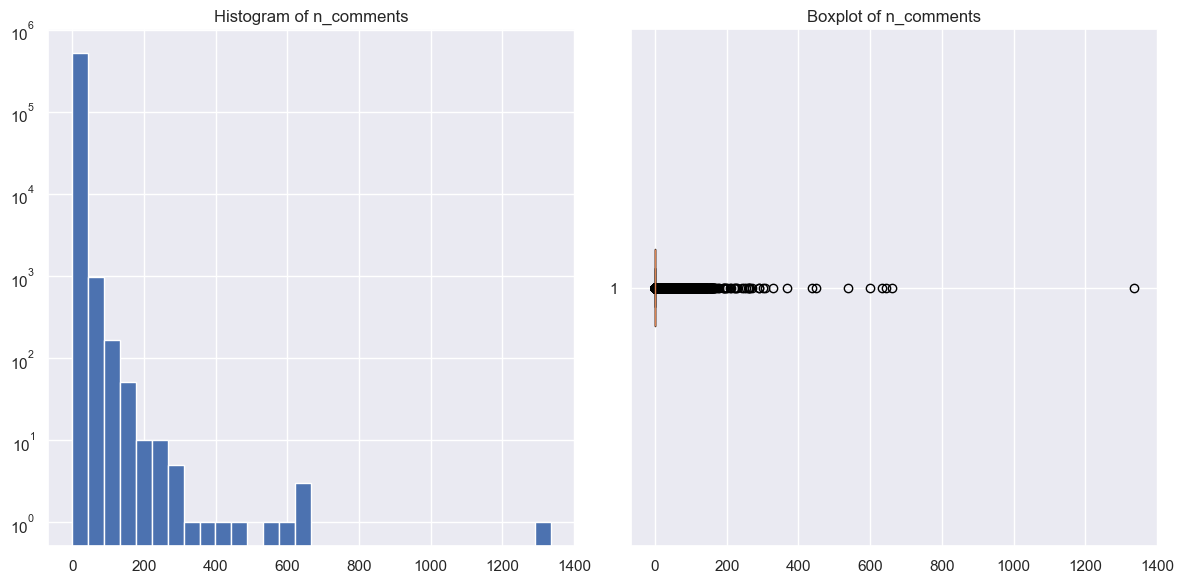

In [53]:
outlier_detection_plot("n_comments")

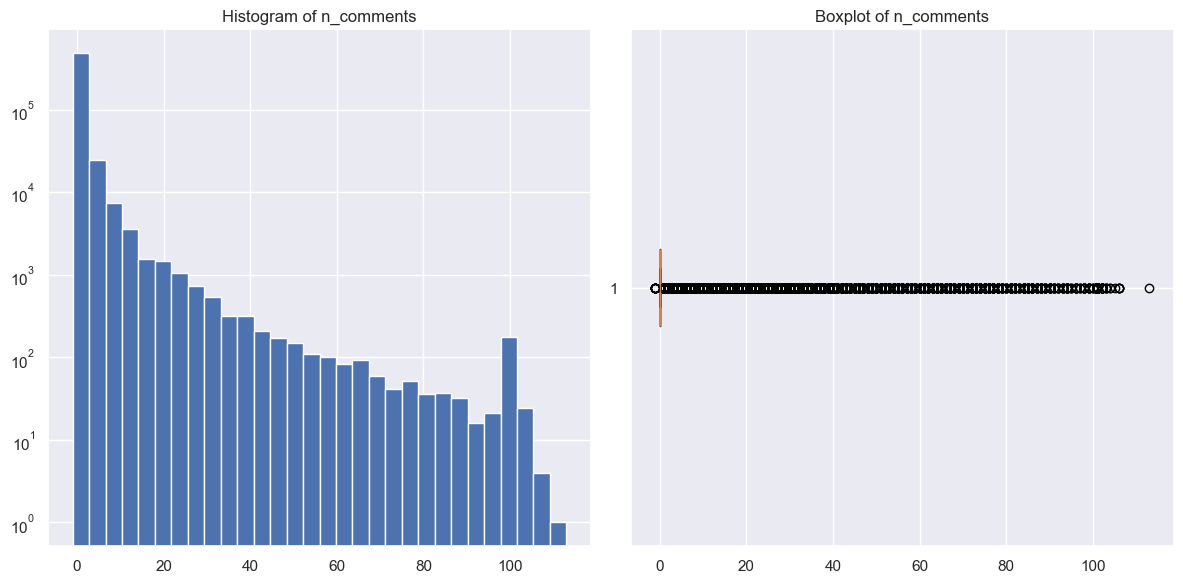

In [54]:
# FIXED VERSION OF N_COMMENTS

train["n_comments"] = train["n_comments"].apply(lambda x: 100+(x//100) if x>100 else x)
outlier_detection_plot("n_comments")

In [55]:
mms_votes = MinMaxScaler()
mms_comments = MinMaxScaler()

# OrdinalEncoder is used to handle unknown values in test set
le_user = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=train.user_id.nunique()+1)
le_book = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=train.book_id.nunique()+1)

# Fix inconsistent values
train["n_votes"] = train["n_votes"].apply(lambda x: max(0,x))
train["n_comments"] = train["n_comments"].apply(lambda x: max(0,x))
# convert label from bool to numeric
train["has_spoiler"] = train["has_spoiler"].apply(lambda x: int(x))
# minMaxScaling for n_votes and n_comments features
train["n_votes"] =  mms_votes.fit_transform(train["n_votes"].values.reshape(-1,1))
train["n_comments"] = mms_comments.fit_transform(train["n_comments"].values.reshape(-1,1))
# label encoding for user_id (to convert into numeric)
train["user_id"] = le_user.fit_transform(train["user_id"].values.reshape(-1,1)).astype(int)
train["book_id"] = le_book.fit_transform(train["book_id"].values.reshape(-1,1)).astype(int)

train["rating"] = train["rating"].apply(lambda x: x/5)

In [56]:
train.describe()

,user_id,book_id,rating,timestamp,n_votes,n_comments,has_spoiler
count,529768.000000,529768.000000,529768.000000,529768,529768.000000,529768.000000,529768.000000
mean,9161.486403,7161.172043,0.739684,2015-04-10 06:01:34.266169600,0.011670,0.008317,0.098024
min,0.000000,0.000000,0.000000,2007-02-27 00:00:00,0.000000,0.000000,0.000000
25%,4599.000000,3961.000000,0.600000,2014-01-06 00:00:00,0.000000,0.000000,0.000000
50%,9184.000000,6890.000000,0.800000,2015-08-16 00:00:00,0.000000,0.000000,0.000000
75%,13749.000000,10436.250000,1.000000,2016-10-15 00:00:00,0.007117,0.000000,0.000000
max,18307.000000,14999.000000,1.000000,2017-11-05 00:00:00,1.000000,1.000000,1.000000
std,5283.910527,4007.027459,0.251619,NaN,0.048030,0.040378,0.297347


In [57]:
train.shape

(529768, 8)

In [58]:
test.shape

(132442, 8)

In [59]:
def test_preprocess(test_df, mms1, mms2, le_user, le_book):
    # Applies the steps applied to the training data to the test set 
    
    test_df["n_votes"] = test_df["n_votes"].apply(lambda x: max(0,x))
    test_df["n_comments"] = test_df["n_comments"].apply(lambda x: max(0,x))
    # convert label into numeric
    test_df["has_spoiler"] = test_df["has_spoiler"].apply(lambda x: int(x))
    # minMaxScaling for n_votes and n_comments features (only transform, not fit)
    test_df["n_votes"] =  mms_votes.transform(test_df["n_votes"].values.reshape(-1,1))
    test_df["n_comments"] = mms_comments.transform(test_df["n_comments"].values.reshape(-1,1))
    # label encoding for user_id (to convert into numeric)
    test_df["user_id"] = le_user.transform(test_df["user_id"].values.reshape(-1,1)).astype(int)
    test_df["book_id"] = le_book.transform(test_df["book_id"].values.reshape(-1,1)).astype(int)
    # scale rating feature 
    test_df["rating"] = test_df["rating"].apply(lambda x: x/5)
    
    return test_df

In [60]:
test_prep = test_preprocess(test, mms_votes, mms_comments, le_user, le_book)

In [63]:
train = train.reset_index(drop=True)
test_prep = test_prep.reset_index(drop=True)

In [66]:
# save train and data sets
train.to_json("./data/train_preprocessed.json")
test_prep.to_json("./data/test.json")

In [67]:
tr = pd.read_json("./data/train_preprocessed.json")
test = pd.read_json("./data/test.json")

In [68]:
tr.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,276,7462,"[[0, This was just an ok read for me.], [0, Pa...",0.6,2013-03-17,0.000000,0.0,0
1,13721,6901,"[[0, Update after finishing the trilogy:], [0,...",0.8,2014-07-27,0.014235,0.0,0
2,13566,8112,"[[0, The Stranger You Know is the third book i...",0.6,2014-03-21,0.000000,0.0,0
3,15837,4119,"[[0, ** spoiler alert **], [0, This was a cool...",0.8,2011-10-19,0.000000,0.0,0
4,16371,8260,"[[0, 4.5 Stars], [0, Have you read Jay Crownov...",1.0,2014-02-23,0.003559,0.0,0


In [69]:
test.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,6423,4388,"[[0, I stumbled across Miss Peregrine's Home f...",0.6,2015-05-15,0.014235,0.000000,0
1,16156,12060,"[[0, 4 STARS], [0, I have alway loved Colleen ...",0.8,2015-11-17,0.113879,0.203540,1
2,10743,4640,"[[0, I enjoyed this story, found it very inter...",0.8,2015-06-19,0.003559,0.000000,0
3,421,7927,"[[0, Original review at Whatever You Can Still...",0.6,2015-05-06,0.000000,0.000000,0
4,10156,13012,"[[0, Love this series... though I'm in absolut...",0.8,2016-10-04,0.049822,0.017699,0


In [42]:
test_prep = test_prep.reset_index(drop=True)

In [43]:
test_prep.head()

,index,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,516192,7404,8422,"[[0, Woooh- So, okay.], [0, I thought A Court ...",0.8,2016-09-18,0.049822,0.000000,0
1,311831,6996,4475,"[[0, WHAT THE FU....!?!?], [0, HOW?], [0, I'm ...",1.0,2015-02-07,0.000000,0.000000,0
2,205297,2858,3439,"[[0, You can guess from the book synopsis that...",0.8,2014-07-26,0.000000,0.000000,0
3,611323,15455,6890,"[[0, This book first appeared on Thoughts and ...",0.8,2015-06-27,0.007117,0.017699,0
4,16911,18323,8129,"[[0, ***THIS REVIEW WILL CONTAIN MAJOR SPOILER...",1.0,2013-07-07,0.000000,0.000000,1


In [44]:
reduced_df.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,8842281e1d1347389f2ab93d60773d4d,18245960,"[[0, This is a special book.], [0, It started ...",5,2017-08-30,28,1,True
1,8842281e1d1347389f2ab93d60773d4d,28684704,"[[0, A fun, fast paced science fiction thrille...",3,2017-03-20,22,0,True
2,8842281e1d1347389f2ab93d60773d4d,25884323,"[[0, I really enjoyed this book, and there is ...",4,2016-04-25,9,1,True
3,8842281e1d1347389f2ab93d60773d4d,19398490,"[[0, A beautiful story.], [0, It is rare to en...",4,2016-09-20,35,5,False
4,8842281e1d1347389f2ab93d60773d4d,22816087,"[[0, I love Stephenson - and this was another ...",5,2016-12-14,40,6,False
